# imports and utils

In [1]:
# model loader - imagenet

import sys
sys.path.append(".")
sys.path.append("./latent-diffusion")
sys.path.append('./taming-transformers')

import torch
from omegaconf import OmegaConf

from ldm.util import instantiate_from_config


def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    # device = torch.device('cpu')
    pl_sd = torch.load(ckpt, weights_only=False, map_location=torch.device('cpu'))
    sd = pl_sd["state_dict"]
    # torch.save(sd, './tmp_sd')
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    if torch.cuda.is_available():
        model.cuda()
    model.eval()
    return model, sd, pl_sd


def get_model(model_config_path, model_ckpt_path):
    config = OmegaConf.load(model_config_path)
    model, sd, pl_sd = load_model_from_config(config, model_ckpt_path)
    return model, sd, pl_sd



In [1]:
# model loader - BraTS

import os
import sys
import torch
sys.path.append(".")
sys.path.append("./brats-mri")
import monai
from PIL import Image
from tqdm import tqdm
from monai.utils import first
from generative.inferers import LatentDiffusionInferer
from generative.networks.schedulers import DDIMScheduler

from torch.utils.data import DataLoader

from pretrained import load_autoencoder, load_unet
import utils

BUNDLE = './brats-mri/brats_mri_class_cond/'
sys.path.append(BUNDLE)
from scripts.inferer import LatentDiffusionInfererWithClassConditioning

def get_monai_autoencoder(bundle_target, training_args, weights_override_path):
    # load autoencoder
    autoencoder = load_autoencoder(bundle_target,
                                   override_model_cfg_json=training_args.config,
                                   override_weights_load_path=weights_override_path)    
    return autoencoder

def get_monai_unet(bundle_target, training_args, weights_override_path):
    unet = load_unet(bundle_target,
                     context_conditioning=training_args.conditioning == 'context',
                     override_model_cfg_json=training_args.config,
                     override_weights_load_path=weights_override_path,
                     use_conditioning=True)
    return unet
    
def get_monai_model_dict(bundle_target, training_args, autoencoder_weights_path, unet_weights_path):
    monai_dict = {}
    training_args = torch.load(os.path.join(output_dir, training_name, 'training_args'))
    monai_dict['autoencoder'] = get_monai_autoencoder(bundle_target, training_args, autoencoder_weights_path)
    monai_dict['unet'] = get_monai_unet(bundle_target, training_args, unet_weights_path)
    
    # set scheduler
    config = utils.model_config(bundle_target, training_args.config)
    monai_dict['scheduler'] = config.get_parsed_content('noise_scheduler')
    # set inferer
    if training_args.conditioning in ['context', 'none']:
        monai_dict['inferer'] = LatentDiffusionInferer(scheduler=scheduler, scale_factor=scale_factor)
    else:
        monai_dict['inferer'] = LatentDiffusionInfererWithClassConditioning(scheduler=scheduler, scale_factor=scale_factor)
    return monai_dict


/opt/conda/envs/monai2/lib/python3.8/site-packages/monai/utils/tf32.py:66: UserWarning: torch.backends.cuda.matmul.allow_tf32 = True by default.
  This value defaults to True when PyTorch version in [1.7, 1.11] and may affect precision.
  See https://docs.monai.io/en/latest/precision_accelerating.html#precision-and-accelerating
  warnings.warn(


In [3]:
# confusion matrix plotter

from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def labels_to_human_labels(labels, human_labels_list):
    human_labels = [human_labels_list[int(x.detach().cpu().numpy())] for x in labels]  
    return human_labels

def plot_confusion_matrix(true_labels, labels_pred, human_labels_list):
    true_labels_readable = labels_to_human_labels(true_labels, human_labels_list)
    labels_pred_readable = labels_to_human_labels(labels_pred, human_labels_list)
    cm = confusion_matrix(true_labels_readable, labels_pred_readable, labels=human_labels_list)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=human_labels_list)
    fig, ax = plt.subplots(figsize=(12,12))
    disp.plot(ax=ax)
    plt.show()

# ImageNet-mini LDM Classifier

In [2]:
# load imagenet pretrained model
import os

def get_model2(model_config_path, model_ckpt_path):
    config = OmegaConf.load(model_config_path)
    model, sd, pl_sd = load_model_from_config(config, model_ckpt_path)
    return model, sd, pl_sd
    
def load_model_from_config2(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt, weights_only=False, map_location=torch.device('cpu'))
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.eval()
    return model.to(device), sd, pl_sd

cin_model_config_path = os.path.join('./latent-diffusion/configs/latent-diffusion/cin256-v2.yaml')
cin_model_ckpt_path = './latent-diffusion/models/ldm/cin256-v2/model.ckpt'

# load model
model, sd, pl_sd = get_model2(cin_model_config_path, cin_model_ckpt_path)
del sd
del pl_sd

Loading model from ./latent-diffusion/models/ldm/cin256-v2/model.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [3]:
import sys
sys.path.append('./diffusion_classifier')
# set ldm classifier

from ldm_classifier_imagenet import LdmClassifier
ldm_clf = LdmClassifier(model)

In [2]:
import sys
sys.path.append('./latent-diffusion/ldm/data/')
from torchvision import transforms
import torch
from matplotlib import pyplot as plt
import numpy as np


from imagenet_mini import ImageNetMiniSubset, ImageNetMiniDataset

# define imagenet-mini subset for classification

val_dir = './data/imagenet-mini/validation'
subset_classes = [3, 852, 14, 222, 888, 173, 405, 16]
imagnet_subset = ImageNetMiniSubset(data_dir=val_dir, labels_file='validation_set.csv', size=256, classes=subset_classes)

print(f"number of samples in dataset: {len(imagnet_subset)}")

FileNotFoundError: [Errno 2] No such file or directory: './data/imagenet-mini/validation/validation_set.csv'

In [8]:
# verify ability to classify single sample:

loader = torch.utils.data.DataLoader(imagnet_subset, batch_size=1, shuffle=False)
batch = next(iter(loader))
c_hypotheses = ldm_clf.get_class_hypotheses_for_batch(batch_size=batch['image'].shape[0], classes=subset_classes)
# x0 = ldm_clf.get_latent_batch(batch)

%time l2_label_pred, l1_label_pred = ldm_clf.classify_batch(batch, c_hypotheses, n_trials=1, t_sampling_stride=50)
print(f"true label: {batch['class_label']}")
print(f"L2 classification: {l2_label_pred}")
print(f"L1 classification: {l1_label_pred}")

class hypothsis:   0%|          | 0/8 [00:00<?, ?it/s]

CPU times: user 2.78 s, sys: 292 ms, total: 3.08 s
Wall time: 3.07 s
true label: tensor([405])
L2 classification: tensor([405])
L1 classification: tensor([405])


In [6]:
# run classification for the entire dataset

l2_labels_pred, l1_labels_pred, true_labels = ldm_clf.classify_dataset(dataset=imagnet_subset,
                                                                       batch_size=1,
                                                                       n_trials=1,
                                                                       t_sampling_stride=50,
                                                                       classes=subset_classes)

dataset samples:   0%|          | 0/108 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/3 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/3 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/3 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/3 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/3 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/3 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/3 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/3 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/3 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/3 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/3 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/3 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/3 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/3 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/3 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/3 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/3 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/3 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/3 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/3 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/3 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/3 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/3 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/3 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/3 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [7]:
l2_acc = ldm_clf.get_classification_accuracy(l2_labels_pred, true_labels)
l1_acc = ldm_clf.get_classification_accuracy(l1_labels_pred, true_labels)

print(f"L2 accuracy: {l2_acc}")
print(f"L1 accuracy: {l1_acc}")

plot_confusion_matrix(true_labels, l2_labels_pred, imagnet_subset.class_names)

L2 accuracy: 99.04153354632588
L1 accuracy: 98.7220447284345


NameError: name 'plot_confusion_matrix' is not defined

# CT RSNA - LDM Classifier

In [2]:
output_dir='outputs'
model_name = "cp_for_weights_only_chk"

In [3]:
# load ct-rsna model
import os

ct_model_config_path = f"./data/{output_dir}/{model_name}/configs/2024-04-27T10-00-13-project.yaml"
ct_model_ckpt_path = f"./data/{output_dir}/{model_name}/checkpoints/last_weights_only.ckpt"

# load model
ct_model, _, _ = get_model(ct_model_config_path, ct_model_ckpt_path)


Loading model from ./data/outputs/cp_for_weights_only_chk/checkpoints/last_weights_only.ckpt


/opt/conda/envs/ldm/lib/python3.8/site-packages/torch/cuda/__init__.py:619: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [12]:
# set ldm classifier


from ldm_classifier import LdmClassifier
ct_ldm_clf = LdmClassifier(ct_model)

In [3]:
import sys
sys.path.append('./latent-diffusion/ldm/data/')
from torchvision import transforms
import torch
from matplotlib import pyplot as plt
import numpy as np

from ct_rsna import CTSubset, CTDataset

# define imagenet-mini subset for classification

val_dir = './data/ct-rsna/validation'
ct_subset = CTSubset(data_dir=val_dir, labels_file='validation_set.csv', size=256, flip_prob=0., subset_len=256)
subset_classes = np.unique(ct_subset.labels).tolist()
print(f"number of samples in dataset: {len(ct_subset)}")

Data source: validation_set.csv
    Class none: 52.3%
    Class epidural: 10.9%
    Class intraparenchymal: 12.9%
    Class intraventricular: 9.8%
    Class subarachnoid: 9.4%
    Class subdural: 4.7%
number of samples in dataset: 256


In [18]:
# verify ability to classify single sample:

loader = torch.utils.data.DataLoader(ct_subset, batch_size=1, shuffle=False)
batch = next(iter(loader))
c_hypotheses = ct_ldm_clf.get_class_hypotheses_for_batch(batch_size=batch['image'].shape[0], classes=subset_classes)
# x0 = ldm_clf.get_latent_batch(batch)

l2_label_pred, l1_label_pred = ct_ldm_clf.classify_batch(batch, c_hypotheses, t_sampling_stride=50)
print(f"true label: {batch['class_label']}")
print(f"L2 classification: {l2_label_pred}")
print(f"L1 classification: {l1_label_pred}")

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

true label: tensor([0])
L2 classification: tensor([1])
L1 classification: tensor([1])


In [19]:
# run classification for the entire dataset

l2_labels_pred, l1_labels_pred, true_labels = ct_ldm_clf.classify_dataset(dataset=ct_subset,
                                                                          batch_size=1,
                                                                          n_trials=1,
                                                                          t_sampling_stride=50,
                                                                          classes=subset_classes)

dataset samples:   0%|          | 0/256 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/20 [00:00<?, ?it/s]

In [29]:
import pickle
with open('tmp_true.npy', 'wb') as f:
    pickle.dump(true_labels, f)
with open('tmp_l2_pred.npy', 'wb') as f:
    pickle.dump(l2_labels_pred, f)


In [30]:
import pickle
with open('tmp_true.npy', 'rb') as f:
    true_labels = pickle.load(f)
with open('tmp_l2_pred.npy', 'rb') as f:
    l2_labels_pred = pickle.load(f)

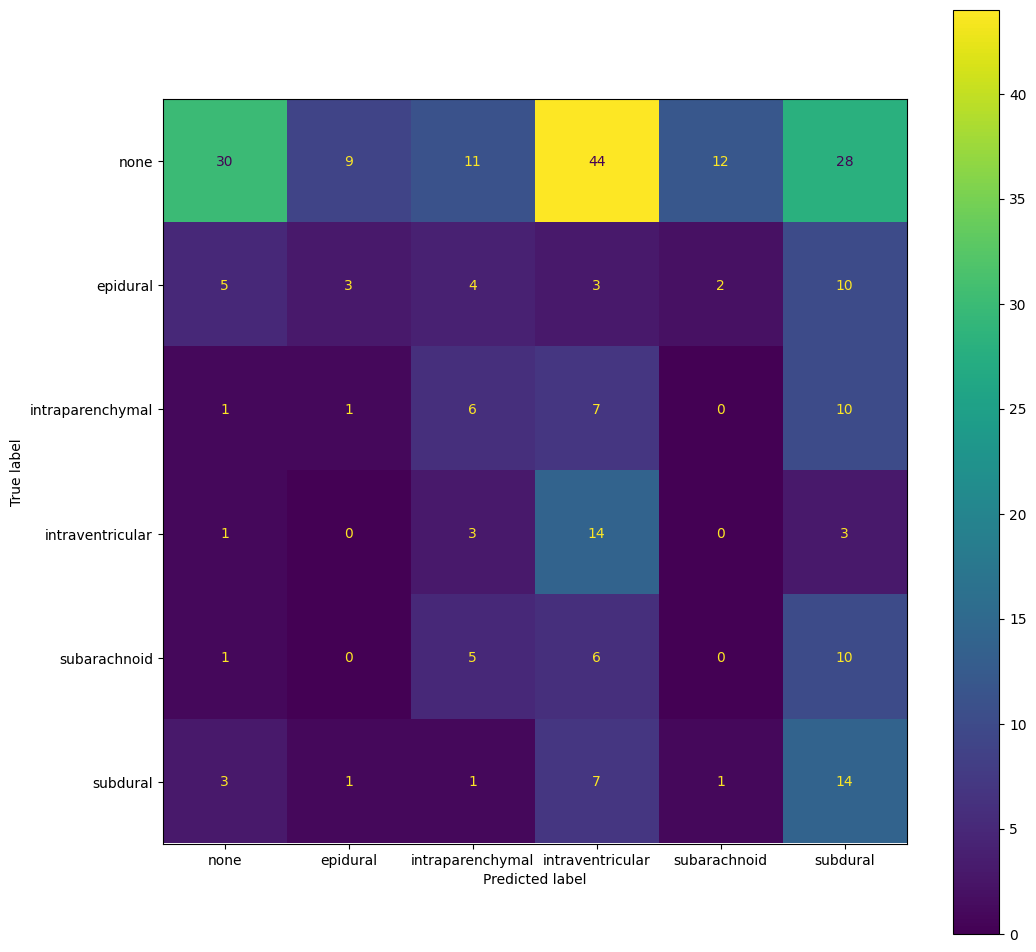

In [33]:
plot_confusion_matrix(true_labels, l2_labels_pred, ct_subset.class_names)

In [20]:
l2_acc = ct_ldm_clf.get_classification_accuracy(l2_labels_pred, true_labels)
l1_acc = ct_ldm_clf.get_classification_accuracy(l1_labels_pred, true_labels)

print(f"L2 accuracy: {l2_acc}")
print(f"L1 accuracy: {l1_acc}")

from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_labels, l2_labels_pred, labels=imagnet_subset.class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                               display_labels=imagnet_subset.class_names)

disp.plot()
plt.show()

L2 accuracy: 26.171875
L1 accuracy: 25.78125


ModuleNotFoundError: No module named 'sklearn'

# Diffusion Classifier - accuracy evaluation

In [4]:
import numpy as np
import torch
# set a fixed random seed (both numpy and torch)
np.random.seed(42)
torch.manual_seed(42)

In [5]:
import os
from enum import Enum
import pickle

from ldm_classifier import LdmClassifier, MonaiLdmClassifier

def get_training_ckpt_files(output_dir, training_name):
  ckpt_dir = os.path.join(output_dir, training_name, 'checkpoints')
  training_ckpt_files = [os.path.join(ckpt_dir, ckpt) for ckpt in os.listdir(ckpt_dir) if 'epoch' in ckpt]
  return training_ckpt_files

def strip_epoch_num_from_ckpt(ckpt_full_path, framework_type):
  ckpt_name = ckpt_full_path.split('/')[-1]
  if framework_type is FrameworkType.Imagenet:
      epoch_num = 1 + int(ckpt_name.split(".")[0].split("=")[-1])
  elif framework_type is FrameworkType.Monai:
      epoch_num = int(ckpt_name.split(".")[0].split("_")[-1])
  else:
      raise ValueError(f'framework_type {framework_type} not in [t for t in FrameworkType]')
  return epoch_num

def get_training_cfg_file(output_dir, training_name):
  cfg_dir = os.path.join(output_dir, training_name, 'configs')
  model_cfg_files = [cfg for cfg in os.listdir(cfg_dir) if 'project' in cfg]
  if len(model_cfg_files) == 0:
    raise ValueError("configs dir empty, you may manualy pass the config file instead")
  if len(model_cfg_files) > 1:
    raise ValueError("more than 1 config file in configs dir, you may manualy pass the config file instead")
  
  return os.path.join(cfg_dir, model_cfg_files[0])


def get_monai_training_ckpt_files(output_dir, training_name):
  ckpt_dir = os.path.join(output_dir, training_name)
  autoencoder_ckpt_files = [os.path.join(ckpt_dir, ckpt) for ckpt in os.listdir(ckpt_dir) if 'autoencoder' in ckpt]
  unet_ckpt_files = [os.path.join(ckpt_dir, ckpt) for ckpt in os.listdir(ckpt_dir) if 'diffusion' in ckpt]
  return autoencoder_ckpt_files, unet_ckpt_files

class FrameworkType(Enum):
    Imagenet = 0
    Monai = 1

def evaluate_accuracy_over_epochs(output_dir, 
                                  training_name, 
                                  dataset, 
                                  framework_type: FrameworkType,
                                  t_sampling_stride = 50,
                                  n_trials = 1
                                 ):
    # create classification results dir under the training dir
    clf_dir = os.path.join(output_dir, training_name, 'classification')
    if not os.path.exists(clf_dir):
        os.makedirs(clf_dir)
    n_pred_files = len(os.listdir(clf_dir))

    clf_res_per_epoch = {'dataset': dataset}
    
    if framework_type is FrameworkType.Imagenet:
        # prepare files
        training_ckpt_files = get_training_ckpt_files(output_dir, training_name)
        cfg_file = get_training_cfg_file(output_dir, training_name)

        # loop over ckpts
        for ckpt_file in training_ckpt_files:
            epoch_num = strip_epoch_num_from_ckpt(ckpt_file, framework_type)
            # load model
            model, _, _ = get_model(cfg_file, ckpt_file)
            # instantiate ldm classifier
            ldm_clf = LdmClassifier(model)    
            # run classification
            l2_labels_pred, l1_labels_pred, true_labels = ldm_clf.classify_dataset(dataset=ds,
                                                                                   batch_size=1,
                                                                                   n_trials=n_trials,
                                                                                   t_sampling_stride=t_sampling_stride)
            # save results
            clf_res_per_epoch[epoch_num] = {
              'true_labels': true_labels,
              'l1_pred_labels': l1_labels_pred,
              'l2_pred_labels': l2_labels_pred,
            }
            with open(os.path.join(clf_dir, f'predictions_{n_pred_files}'), 'wb') as f:
                pickle.dump(clf_res_per_epoch, f)
            
            # delete model
            del model
            del ldm_clf
    
    elif framework_type is FrameworkType.Monai:
        bundle_target
        # prepare files
        autencoder_ckpt_files, unet_ckpt_files = get_monai_training_ckpt_files(output_dir, training_name)
        # loop over ckpts
        for autoenc_ckpt, unet_ckpt in zip(autencoder_ckpt_files, unet_ckpt_files):
            epoch_num = strip_epoch_num_from_ckpt(autoenc_ckpt, framework_type)
            # load model
            model_dict = get_monai_model_dict(BUNDLE, training_args, autoenc_ckpt, unet_ckpt)
            # instantiate ldm classifier
            ldm_clf = MonaiLdmClassifier(**model_dict)
            # run classification
            l2_labels_pred, l1_labels_pred, true_labels = ldm_clf.classify_dataset(dataset=ds,
                                                                                   batch_size=1,
                                                                                   n_trials=n_trials,
                                                                                   t_sampling_stride=t_sampling_stride)
            # save results
            clf_res_per_epoch[epoch_num] = {
              'true_labels': true_labels,
              'l1_pred_labels': l1_labels_pred,
              'l2_pred_labels': l2_labels_pred,
            }
            with open(os.path.join(clf_dir, f'predictions_{n_pred_files}'), 'wb') as f:
                pickle.dump(clf_res_per_epoch, f)
            
            # delete model
            del model
            del ldm_clf
    else:
        raise ValueError(f'framework_type {framework_type} not in [t for t in FrameworkType]')
    return clf_res_per_epoch



ValueError: transformers.__spec__ is None

# ImageNet LDM accuracy evaluation

In [1]:
import sys
sys.path.append('./latent-diffusion/ldm/data/')
from ct_rsna import CTDataset, CTSubset
from torchvision import transforms
import torch
from matplotlib import pyplot as plt
import numpy as np


ModuleNotFoundError: No module named 'pandas'

In [ ]:
# prepare data
train_dir = './data/ct-rsna/train'
val_dir = './data/ct-rsna/validation'

subset_len = 1
ds = CTSubset(data_dir=val_dir, labels_file='validation_set_dropped_nans.csv', size=256, flip_prob=0., subset_len=subset_len)

# LDM classifier params
t_sampling_stride = 50
n_trials = 1

# training dir
output_dir = './data/outputs'
training_name = '2024-05-10T17-04-36_imagenet-1024'

# evaluate
clf_res_per_epoch = evaluate_accuracy_over_epochs(output_dir, 
                                                  training_name, 
                                                  ds, 
                                                  FrameworkType.Imagenet,
                                                  t_sampling_stride,
                                                  n_trials)


Loading model from ./data/outputs/2024-05-10T17-04-36_imagenet-1024/checkpoints/epoch=000004.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


dataset samples:   0%|          | 0/1 [00:00<?, ?it/s]

class hypothsis:   0%|          | 0/6 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/2 [00:00<?, ?it/s]

/opt/conda/envs/ldm/lib/python3.8/site-packages/torch/amp/autocast_mode.py:250: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn(


diffusion sampling:   0%|          | 0/2 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/2 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/2 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/2 [00:00<?, ?it/s]

diffusion sampling:   0%|          | 0/2 [00:00<?, ?it/s]

Loading model from ./data/outputs/2024-05-10T17-04-36_imagenet-1024/checkpoints/epoch=000009.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


# MONAI - classification accuracy evaluation

In [1]:
import sys
sys.path.append('./latent-diffusion/ldm/data/')
from ct_rsna import CTDataset, CTSubset
from torchvision import transforms
import torch
from matplotlib import pyplot as plt
import numpy as np

/opt/conda/envs/monai/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [ ]:
# prepare data
train_dir = './data/ct-rsna/train'
val_dir = './data/ct-rsna/validation'

subset_len = 1
ds = CTSubset(data_dir=val_dir, labels_file='validation_set_dropped_nans.csv', size=256, flip_prob=0., subset_len=subset_len)

# LDM classifier params
t_sampling_stride = 50
n_trials = 1

# training dir
output_dir = './data/outputs'
training_name = '2024-05-10T17-04-36_imagenet-1024'

# evaluate
clf_res_per_epoch = evaluate_accuracy_over_epochs(output_dir, 
                                                  training_name, 
                                                  ds, 
                                                  FrameworkType.Monai,
                                                  t_sampling_stride,
                                                  n_trials)
